## 0. 导入库函数与数据预处理

In [ ]:
# 1. 导入所需库
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from kneed import KneeLocator # 用于检测肘部点

import warnings
warnings.filterwarnings('ignore')

# 展示高清图 
from matplotlib_inline import backend_inline 
backend_inline.set_matplotlib_formats('svg') 

print("所有库已成功导入！")

所有库已成功导入！


In [ ]:
# 加载数据
df = pd.read_csv('alldata.csv')

# 查看数据基本信息
print("数据集基本信息：")
print(f"数据形状: {df.shape}")
print(f"学科数量: {df['subject_name'].nunique()}")

# 缺失值处理
print(f"缺失值统计：",df.isnull().sum())
df = df.dropna()
print("\n缺失值处理后数据形状: ", df.shape)

数据集基本信息：
数据形状: (34121, 9)
学科数量: 22
缺失值统计： id                             0
subject_name                   0
institution_name               0
country_region              3161
world_rank                     0
web_of_science_documents       0
cites                          0
cites_per_paper                0
top_papers                     0
dtype: int64

缺失值处理后数据形状:  (30960, 9)


## 2.全球学科聚类分析
实现步骤：特征工程（为聚类分析做准备）-->确定最佳聚类k值-->进行kmeans聚类-->聚类结果分析并找到与华师大相似高校

### 2.1 特征工程

In [ ]:
# 特征工程
print("特征工程：构建学科矩阵 -> 类别聚合 -> 降维 -> 标准化")

# 学科列表与机构分组
all_subjects = sorted(df['subject_name'].unique())
grouped = df.groupby('institution_name')

# 定义学科类别映射（用于后续按类别聚合）
# 保持与后面深度画像分析中使用的类别一致
subject_categories = {
    'basic science': ['chemistry', 'physics', 'mathematics', 'geosciences'],
    'bioscience': ['biology & biochemistry', 'plant & animal science', 'molecular biology & genetics',
                 'microbiology', 'neuroscience & behavior', 'immunology'],
    'midecal': ['clinical medicine', 'pharmacology & toxicology', 'psychiatry psychology'],
    'engineering&tech': ['engineering', 'materials science', 'computer science'],
    'ecology': ['agricultural sciences', 'environment ecology'],
    'social science': ['social sciences, general', 'economics & business'],
    'others': ['multidisciplinary', 'space science']
}

# 存放行数据
university_names = []
presence_rows = []
perf_rows = []
impact_rows = []
scale_rows = []
subject_counts = []
avg_ranks = []

for uni, uni_df in grouped:
    if len(uni_df) < 3:  # 可调整阈值
        continue
    university_names.append(uni)
    subject_counts.append(len(uni_df))
    avg_ranks.append(uni_df['world_rank'].mean())

    # 用 subject_name 对齐到 all_subjects，方便向量化
    s = uni_df.set_index('subject_name')
    s = s.reindex(all_subjects)

    pres = s['world_rank'].notna().astype(int).fillna(0).values
    #perf = s['world_rank'].apply(lambda r: max(0, (2000 - r) / 2000) if pd.notna(r) else 0.0).fillna(0).values
    perf = s['world_rank'].apply(lambda r: 1 / (1 + np.exp((r - 100) / 50)) if pd.notna(r) else 0.0).fillna(0).values
    imp = s['cites_per_paper'].apply(lambda x: min(1.0, x / 50) if pd.notna(x) else 0.0).fillna(0).values
    sca = s['web_of_science_documents'].apply(lambda x: min(1.0, x / 5000) if pd.notna(x) else 0.0).fillna(0).values

    presence_rows.append(pres)
    perf_rows.append(perf)
    impact_rows.append(imp)
    scale_rows.append(sca)

# 转为 DataFrame（索引为机构名）
presence_df = pd.DataFrame(presence_rows, columns=[f'has_{s}' for s in all_subjects], index=university_names)
perf_df = pd.DataFrame(perf_rows, columns=[f'perf_{s}' for s in all_subjects], index=university_names)
impact_df = pd.DataFrame(impact_rows, columns=[f'impact_{s}' for s in all_subjects], index=university_names)
scale_df = pd.DataFrame(scale_rows, columns=[f'scale_{s}' for s in all_subjects], index=university_names)

# 检查矩阵一致性
assert presence_df.shape[0] == perf_df.shape[0], '行数不一致'
assert presence_df.shape[1] == len(all_subjects), '列数与学科数量不匹配'

# 类别强度：基于 perf 与 impact 的均值聚合（更稳健且可解释）
category_strengths = pd.DataFrame(index=university_names)
for cat, subs in subject_categories.items():
    perf_cols = [f'perf_{s}' for s in subs if f'perf_{s}' in perf_df.columns]
    imp_cols = [f'impact_{s}' for s in subs if f'impact_{s}' in impact_df.columns]

    # 计算类别内的 perf_mean 与 impact_mean；若某一项缺失则用0填充
    mean_perf = perf_df[perf_cols].mean(axis=1) if perf_cols else pd.Series(0.0, index=university_names)
    mean_imp = impact_df[imp_cols].mean(axis=1) if imp_cols else pd.Series(0.0, index=university_names)

    # 将两者平均作为类别实力得分（可后续调整权重）
    category_strengths[f'category_{cat}'] = (mean_perf + mean_imp) / 2.0

# 对 presence / perf 做降维以降低维度（保留信息）
max_components = min(8, max(1, len(all_subjects) - 1))

svd_pres = TruncatedSVD(n_components=max_components, random_state=42)
pres_comp = svd_pres.fit_transform(presence_df)
pres_cols = [f'pres_comp_{i+1}' for i in range(pres_comp.shape[1])]
pres_df = pd.DataFrame(pres_comp, index=university_names, columns=pres_cols)

svd_perf = TruncatedSVD(n_components=min(max_components, perf_df.shape[1]), random_state=42)
perf_comp = svd_perf.fit_transform(perf_df)
perf_cols = [f'perf_comp_{i+1}' for i in range(perf_comp.shape[1])]
perf_comp_df = pd.DataFrame(perf_comp, index=university_names, columns=perf_cols)

# 合并用于聚类的特征
university_features_matrix = pd.concat([
    pres_df, perf_comp_df, category_strengths,
    pd.DataFrame({'subject_count': subject_counts, 'avg_rank': avg_ranks}, index=university_names)
], axis=1)

print(f"降维后特征矩阵形状: {university_features_matrix.shape}")

# 标准化
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(university_features_matrix)
X_cluster_scaled_df = pd.DataFrame(X_scaled, index=university_names, columns=university_features_matrix.columns)

# 基本信息字典（供后续分析使用）
university_basic_info = {u: {'subject_count': subject_counts[i], 'avg_rank': avg_ranks[i],
                             'best_rank': df[df['institution_name']==u]['world_rank'].min(),
                             'country_region': df[df['institution_name']==u]['country_region'].iloc[0],
                             'subjects': df[df['institution_name']==u]['subject_name'].tolist()}
                         for i,u in enumerate(university_names)}

print('\n特征工程完成，已生成 X_cluster_scaled_df 与 university_basic_info。')

特征工程：构建学科矩阵 -> 类别聚合 -> 降维 -> 标准化
降维后特征矩阵形状: (3198, 25)
降维后特征矩阵形状: (3198, 25)

特征工程完成，已生成 X_cluster_scaled_df 与 university_basic_info。

特征工程完成，已生成 X_cluster_scaled_df 与 university_basic_info。


### 2.2 利用肘部法则确定最佳k值

TypeError: 'Axes' object is not subscriptable

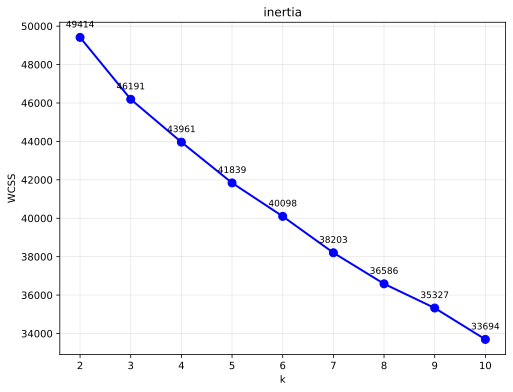

In [ ]:
# -----确定最优聚类数量-----
def evaluate_clustering(X, k_range):
    """评估不同聚类数量的效果"""
    inertias = []
    
    for k in k_range:
        # K-means聚类
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        # 利用WCSS计算评估指标
        inertias.append(kmeans.inertia_)
    return inertias

# 测试聚类数量范围（2-10）
k_range = range(2, 11)
# 使用 X_cluster_scaled_df 作为聚类评估输入
inertias = evaluate_clustering(X_cluster_scaled_df, k_range)

#------绘制评估结果-----
fig, axes = plt.subplots(figsize=(8, 6))

# 肘部法则（画图）
axes.plot(k_range, inertias, 'bo-', markersize=8, linewidth=2)
axes.set_xlabel('k')
axes.set_ylabel('WCSS') # 簇内平方和
axes.set_title('inertia')
axes.grid(True, alpha=0.3)

# 添加注释
for i, (k, inertia) in enumerate(zip(k_range, inertias)):
    axes.annotate(f'{inertia:.0f}', (k, inertia), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

kl = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
best_k_elbow = kl.elbow
optimal_k = best_k_elbow
# 仅当 KneeLocator 返回的肘部在 k_range 内且可索引时才取值
if best_k_elbow is not None and best_k_elbow in list(k_range):
    try:
        best_elbow = inertias[list(k_range).index(best_k_elbow)]
    except Exception:
        best_elbow = None

# 检测到有效肘部时在图上标注（放在 inertia 图上），避免对 None 执行加法
if best_k_elbow is not None and best_elbow is not None:
    axes.scatter([best_k_elbow], [best_elbow], color='green', s=100, zorder=5)
    axes.annotate(f'best k={best_k_elbow}', 
                    xy=(best_k_elbow, best_elbow),
                    xytext=(best_k_elbow+0.5, best_elbow+0.01),
                    arrowprops=dict(arrowstyle='->', color='green'))
else:
    # 在子图角落标注未检测到肘部
    axes.text(0.98, 0.95, '未检测到明显肘部', ha='right', va='top', transform=axes.transAxes, fontsize=9, color='gray')

# 打印友好提示（根据是否存在有效肘部给出不同输出）
if best_k_elbow is None or best_elbow is None:
    print(f"基于肘部法则推荐的聚类数量: 未检测到明显肘部")
else:
    print(f"基于肘部法则推荐的聚类数量: k = {best_k_elbow} (WCSS: {best_elbow:.0f})")

### 2.3 执行聚类

In [ ]:
# 执行最终聚类分析（已修复：使用 X_cluster_scaled_df 作为主数据）
print("="*80)
print("执行最终聚类分析")
print("="*80)

# 使用 X_cluster_scaled_df作为聚类输入
X_df = X_cluster_scaled_df.copy()

# 使用之前确定的聚类数量
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_df.values)

print(f"最终聚类结果 (k={optimal_k}):")

# 将聚类标签写回 DataFrame
X_cluster_scaled_df['cluster'] = labels

# 分析聚类分布
cluster_counts = X_cluster_scaled_df['cluster'].value_counts().sort_index()
print("各聚类大小分布:")
for cluster_id, count in cluster_counts.items():
    percentage = count / len(X_cluster_scaled_df) * 100
    print(f"聚类 {cluster_id}: {count} 所高校 ({percentage:.1f}%)")
print()

# 分析华师大所在聚类
target = 'EAST CHINA NORMAL UNIVERSITY'
ecnu_cluster = int(X_cluster_scaled_df.loc[target, 'cluster'])
ecnu_cluster_size = int(cluster_counts.get(ecnu_cluster, 0))
print(f"华东师范大学所在聚类: 聚类 {ecnu_cluster}")
print(f"该聚类包含 {ecnu_cluster_size} 所高校 ({ecnu_cluster_size/len(X_cluster_scaled_df)*100:.1f}%)")

### 2.4 聚类结果分析并找到与华师大相似高校

In [ ]:
# 聚类结果分析
print("="*80)
print("聚类结果分析")
print("="*80)

print("聚类分布概览:")
for cluster_id in sorted(X_cluster_scaled_df['cluster'].unique()):
    cluster_unis = X_cluster_scaled_df[X_cluster_scaled_df['cluster'] == cluster_id].index.tolist()
    count = len(cluster_unis)
    percentage = count / len(X_cluster_scaled_df) * 100
    print(f"\n聚类 {cluster_id}: 高校数量: {count} 所 ({percentage:.1f}%)")

    # 显示代表性高校（根据 best_rank 排序）
    rep_sorted = sorted(
        cluster_unis,
        key=lambda u: university_basic_info.get(u, {}).get('best_rank', float('inf'))
    )
    print(f"  代表性高校（前5所）:")
    for i, uni in enumerate(rep_sorted[:5]):
        countryRegion = university_basic_info[uni]['country_region']
        print(f"    {i+1}. {uni} (国家: {countryRegion})")


# =============================
# 分析华东师范大学及最相似高校
# =============================
target = 'EAST CHINA NORMAL UNIVERSITY' # 这里有需要也可以改为其他学校的名字

# 获取 ECNU 的聚类信息
ecnu_cluster = int(X_cluster_scaled_df.loc[target, 'cluster'])
ecnu_cluster_size = int((X_cluster_scaled_df['cluster'] == ecnu_cluster).sum())
print(f"{target}所属聚类: 聚类 {ecnu_cluster} ，该聚类包含 {ecnu_cluster_size} 所高校")

# 提取该聚类中所有高校的特征向量（不含 cluster 标签）
same_cluster_mask = (X_cluster_scaled_df['cluster'] == ecnu_cluster)
cluster_features = X_cluster_scaled_df[same_cluster_mask].drop(columns=['cluster'])  # 去掉标签列

# 提取 ECNU 的特征向量
ecnu_vector = X_cluster_scaled_df.loc[target].drop('cluster')  # Series without cluster

# 计算每所高校与 ECNU 的欧氏距离
from scipy.spatial.distance import cdist
distances = cdist(
    cluster_features.values,
    ecnu_vector.values.reshape(1, -1),
    metric='euclidean'
).flatten()

# 构建 (大学名, 距离) 列表，并按距离升序排列
similar_pairs = [(name, dist) for name, dist in zip(cluster_features.index, distances)]
similar_pairs.sort(key=lambda x: x[1])  # 按距离从小到大排序

# 排除 ECNU 自身，取 Top-K 最相似高校
top_k = 30
similar_unis = [item for item in similar_pairs if item[0] != target][:top_k]

print(f"\n与{target}最相似的 {len(similar_unis)} 所高校（基于特征向量距离排序）:")
for i, (uni, dist) in enumerate(similar_unis):
    info = university_basic_info.get(uni, {})
    avg_r = info.get('avg_rank', 'N/A')
    best_r = info.get('best_rank', 'N/A')
    country = info.get('country_region', '未知')
    print(f"  {i+1:2d}. {uni}| 地区: {country} | 相似距离: {dist:.3f} | 平均排名: {avg_r:.1f} | 最好排名: {best_r} ")